### Cell 1: Imports and Configuration

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
import logging

# Configure logging for better maintainability and robustness
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')

# Set aesthetic style for visualizations
sns.set_theme(style="whitegrid")
%matplotlib inline

### Cell 2:  Load the Dataset

In [9]:
def load_raw_data(file_path):
    """
    Loads the full CFPB complaint dataset from a CSV file.
    Args: file_path (str): Path to the raw complaints.csv.
    Returns: pd.DataFrame: The loaded dataset.
    """
    if not os.path.exists(file_path):
        logging.error(f"File not found at {file_path}")
        return None
    
    logging.info("Loading full dataset... this may take a moment.")
    df = pd.read_csv(file_path, low_memory=False)
    logging.info(f"Initial Dataset Shape: {df.shape}")
    return df

# Adjust this path based on your local structure
RAW_DATA_PATH = '../data/raw/complaints.csv'
df_raw = load_raw_data(RAW_DATA_PATH)
df_raw.head()

INFO: Loading full dataset... this may take a moment.
INFO: Initial Dataset Shape: (9609797, 18)


,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2025-06-20,Credit reporting or other personal consumer re...,Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,NaN,Experian Information Solutions Inc.,FL,32092,NaN,NaN,Web,2025-06-20,In progress,Yes,NaN,14195687
1,2025-06-20,Debt collection,Telecommunications debt,Attempts to collect debt not owed,Debt is not yours,NaN,Company can't verify or dispute the facts in t...,"Eastern Account Systems of Connecticut, Inc.",FL,342XX,NaN,NaN,Web,2025-06-20,Closed with explanation,Yes,NaN,14195688
2,2025-06-20,Credit reporting or other personal consumer re...,Credit reporting,Improper use of your report,Reporting company used your report improperly,NaN,NaN,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",AZ,85225,NaN,NaN,Web,2025-06-20,In progress,Yes,NaN,14195689
3,2025-06-20,Credit reporting or other personal consumer re...,Credit reporting,Improper use of your report,Reporting company used your report improperly,NaN,NaN,Experian Information Solutions Inc.,AZ,85225,NaN,NaN,Web,2025-06-20,In progress,Yes,NaN,14195690
4,2025-06-20,Credit reporting or other personal consumer re...,Credit reporting,Incorrect information on your report,Account status incorrect,NaN,NaN,Experian Information Solutions Inc.,IL,60628,NaN,NaN,Web,2025-06-20,In progress,Yes,NaN,14195692


### Cell 3: Distribution of Complaints by Product

C:\Users\user\AppData\Local\Temp\ipykernel_23360\2218969999.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=product_counts.index[:15], x=product_counts.values[:15], palette='viridis')


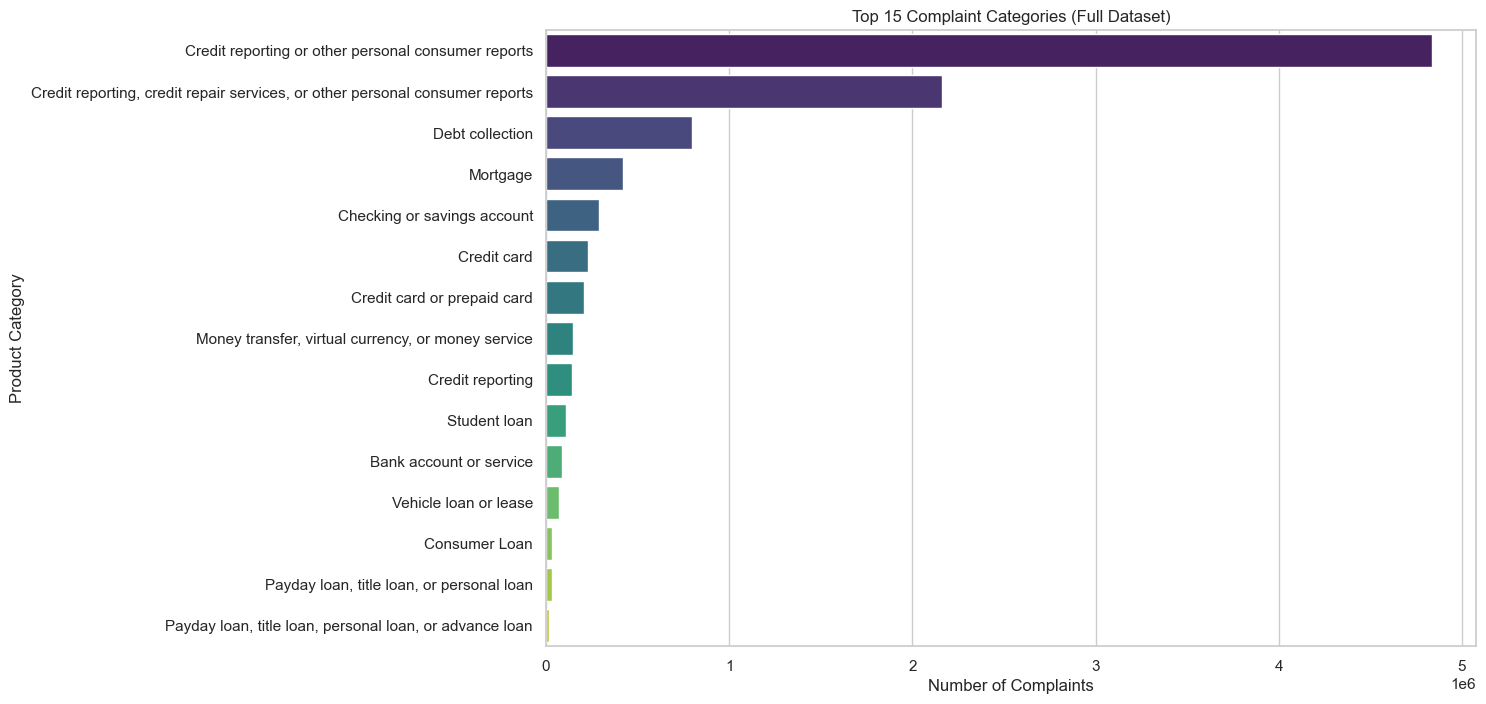


Complaints per Product (Top 10):
 Product
Credit reporting or other personal consumer reports                             4834855
Credit reporting, credit repair services, or other personal consumer reports    2163857
Debt collection                                                                  799197
Mortgage                                                                         422254
Checking or savings account                                                      291178
Credit card                                                                      226686
Credit card or prepaid card                                                      206369
Money transfer, virtual currency, or money service                               145066
Credit reporting                                                                 140429
Student loan                                                                     109717
Name: count, dtype: int64


In [10]:
# Analyze distribution across all products
product_counts = df_raw['Product'].value_counts()

plt.figure(figsize=(12, 8))
sns.barplot(y=product_counts.index[:15], x=product_counts.values[:15], palette='viridis')
plt.title("Top 15 Complaint Categories (Full Dataset)")
plt.xlabel("Number of Complaints")
plt.ylabel("Product Category")
plt.show()

print("\nComplaints per Product (Top 10):\n", product_counts.head(10))

### Cell 4: Filtering for CrediTrust Products

In [11]:
def filter_credi_trust_data(df):
    """
    Filters dataset for specific CrediTrust products and removes records without narratives.
    Assumptions: Target products are mapped based on CFPB naming conventions.
    """
    # Mapping the specific products requested in the project document
    target_products = [
        'Credit card', 'Credit card or prepaid card',                     # Credit Cards
        'Consumer Loan', 'Payday loan, title loan, or personal loan',      # Personal Loans
        'Checking or savings account', 'Bank account or service',          # Savings Accounts
        'Money transfer, virtual currency, or money service',              # Money Transfers
        'Money transfers'                                                 # Money Transfers (Alt)
    ]
    
    # Filter by Product
    df_filtered = df[df['Product'].isin(target_products)].copy()
    
    # Identify complaints with and without narratives (EDA requirement)
    total_filtered = len(df_filtered)
    has_narrative = df_filtered['Consumer complaint narrative'].notnull().sum()
    no_narrative = total_filtered - has_narrative
    
    logging.info(f"Records with narratives: {has_narrative}")
    logging.info(f"Records without narratives: {no_narrative} (will be removed)")
    
    # Remove records without narratives
    df_filtered = df_filtered[df_filtered['Consumer complaint narrative'].notnull()]
    
    return df_filtered

df_filtered = filter_credi_trust_data(df_raw)

INFO: Records with narratives: 469922
INFO: Records without narratives: 553151 (will be removed)


### Cell 5: Narrative Length Analysis 

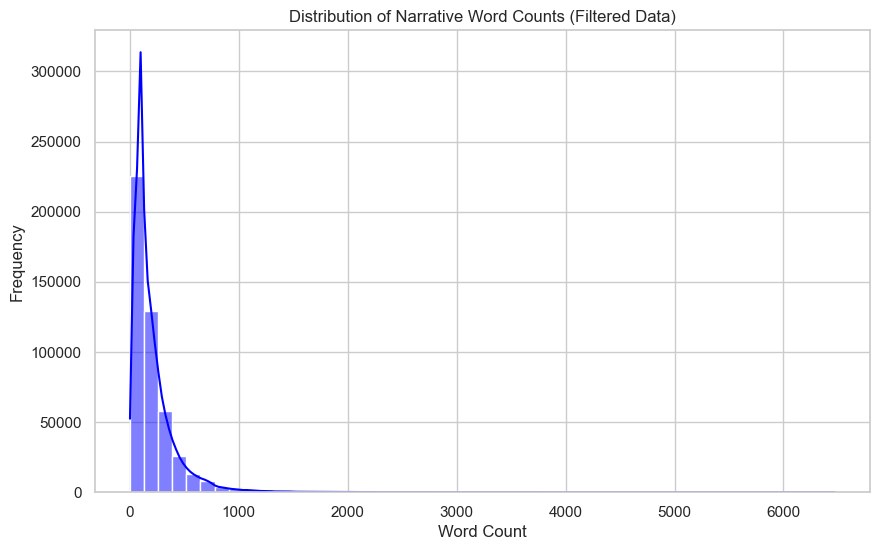

count    469922.000000
mean        205.896087
std         225.587084
min           1.000000
25%          83.000000
50%         138.000000
75%         256.000000
max        6469.000000
Name: narrative_length, dtype: float64


In [12]:
# Calculate word counts for EDA
df_filtered['narrative_length'] = df_filtered['Consumer complaint narrative'].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(10, 6))
sns.histplot(df_filtered['narrative_length'], bins=50, kde=True, color='blue')
plt.title("Distribution of Narrative Word Counts (Filtered Data)")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.show()

# Statistical summary of lengths
print(df_filtered['narrative_length'].describe())

### Cell 6: Advanced Text Cleaning 

In [13]:
def clean_complaint_text(text):
    """
    Cleans raw narrative text for better embedding quality.
    - Lowercases text for standardization.
    - Removes common boilerplate introductory phrases.
    - Removes special characters but keeps spaces and standard punctuation.
    """
    if not isinstance(text, str):
        return ""
    
    # Lowercase text
    text = text.lower()
    
    # Remove boilerplate phrases like "I am writing to file a complaint"
    text = re.sub(r"i am writing to file a complaint regarding", "", text)
    text = re.sub(r"i am writing to file a complaint", "", text)
    
    # Remove special characters/numbers to focus on semantic word meaning
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

logging.info("Starting text cleaning pipeline...")
df_filtered['cleaned_narrative'] = df_filtered['Consumer complaint narrative'].apply(clean_complaint_text)
logging.info("Text cleaning complete.")

INFO: Starting text cleaning pipeline...
INFO: Text cleaning complete.


### Cell 7: Save Processed Dataset 

In [14]:
# Create directory if it doesn't exist
OUTPUT_DIR = '../data/processed'
os.makedirs(OUTPUT_DIR, exist_ok=True)

OUTPUT_FILE = os.path.join(OUTPUT_DIR, 'filtered_complaints.csv')
df_filtered.to_csv(OUTPUT_FILE, index=False)

logging.info(f"Task 1 Complete: Dataset saved to {OUTPUT_FILE}")
print(f"Final shape of cleaned dataset: {df_filtered.shape}")

INFO: Task 1 Complete: Dataset saved to ../data/processed\filtered_complaints.csv


Final shape of cleaned dataset: (469922, 20)
